In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt

In [6]:

# Load and preprocess the Mona Lisa image
image_path="/content/monalisa.jpg"
def load_mona_lisa(image_path, img_size=(128, 128)):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    ])

    original_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])

    image = Image.open(image_path)
    grayscale_image = transform(image).unsqueeze(0)  # Add batch dimension
    original_image = original_transform(image).unsqueeze(0)

    return grayscale_image, original_image

Creating the autoencoder...
Training the autoencoder...
Epoch [50/2000], Loss: 0.0237
Epoch [100/2000], Loss: 0.0122
Epoch [150/2000], Loss: 0.0100
Epoch [200/2000], Loss: 0.0095
Epoch [250/2000], Loss: 0.0092
Epoch [300/2000], Loss: 0.0089
Epoch [350/2000], Loss: 0.0088
Epoch [400/2000], Loss: 0.0086
Epoch [450/2000], Loss: 0.0086
Epoch [500/2000], Loss: 0.0085
Epoch [550/2000], Loss: 0.0084
Epoch [600/2000], Loss: 0.0083
Epoch [650/2000], Loss: 0.0083
Epoch [700/2000], Loss: 0.0082
Epoch [750/2000], Loss: 0.0082
Epoch [800/2000], Loss: 0.0082
Epoch [850/2000], Loss: 0.0081
Epoch [900/2000], Loss: 0.0081
Epoch [950/2000], Loss: 0.0081
Epoch [1000/2000], Loss: 0.0081
Epoch [1050/2000], Loss: 0.0080
Epoch [1100/2000], Loss: 0.0080
Epoch [1150/2000], Loss: 0.0080
Epoch [1200/2000], Loss: 0.0080
Epoch [1250/2000], Loss: 0.0080
Epoch [1300/2000], Loss: 0.0079
Epoch [1350/2000], Loss: 0.0079
Epoch [1400/2000], Loss: 0.0079
Epoch [1450/2000], Loss: 0.0079
Epoch [1500/2000], Loss: 0.0079
Epoc

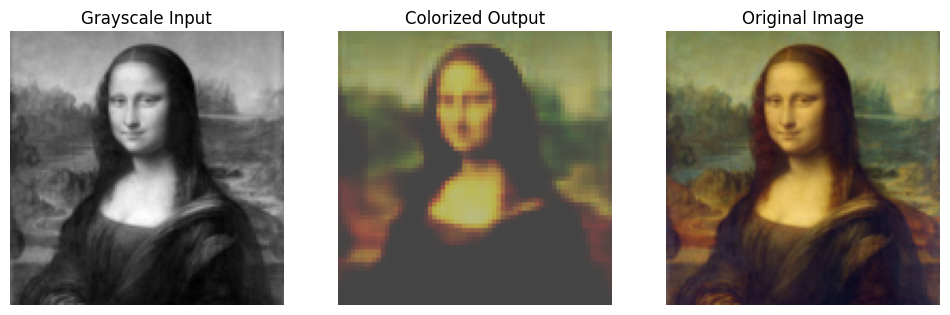

In [9]:



# Define Encoder
def create_encoder():
    downsampling = nn.Sequential(
        # Input: [1, 128, 128] -> Output: [64, 126, 126]
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Downsample: [64, 126, 126] -> [64, 63, 63]

        # Input: [64, 63, 63] -> Output: [128, 61, 61]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Downsample: [128, 61, 61] -> [128, 30, 30]

        # Input: [128, 30, 30] -> Output: [256, 28, 28]
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)  # Downsample: [256, 28, 28] -> [256, 14, 14]
    )
    return downsampling

# Define Decoder
def create_encoder():
    downsampling = nn.Sequential(
        # Input: [1, 128, 128] -> Output: [64, 126, 126]
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Downsample: [64, 126, 126] -> [64, 63, 63]

        # Input: [64, 63, 63] -> Output: [128, 61, 61]
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Downsample: [128, 61, 61] -> [128, 30, 30]

        # Input: [128, 30, 30] -> Output: [256, 28, 28]
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)  # Downsample: [256, 28, 28] -> [256, 14, 14]
    )
    return downsampling

# Define Decoder without striding
def create_decoder():
    upsampling = nn.Sequential(
        # Input: [256, 14, 14] -> Output: [128, 28, 28]
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: [128, 28, 28] -> [128, 28, 28]

        # Input: [128, 28, 28] -> Output: [64, 56, 56]
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: [64, 56, 56] -> [64, 56, 56]

        # Input: [64, 56, 56] -> Output: [3, 112, 112]
        nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
        nn.Tanh(),
        nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample: [3, 112, 112] -> [3, 128, 128]

        nn.Sigmoid()  # Ensure output is in [0, 1]
    )
    return upsampling

# Define Autoencoder
def create_autoencoder():
    encoder = create_encoder()
    decoder = create_decoder()

    def forward(x):
        latent = encoder(x)
        reconstructed = decoder(latent)
        return reconstructed

    return encoder, decoder, forward

# Training loop
def train_autoencoder(encoder, decoder, forward, grayscale_image, original_image, epochs=2000, lr=0.0001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()

        optimizer.zero_grad()
        output = forward(grayscale_image)
        loss = criterion(output, original_image)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Test the model and visualize the output
def visualize_results(forward, grayscale_image, original_image):
    with torch.no_grad():
        output = forward(grayscale_image).squeeze(0).permute(1, 2, 0).numpy()

    grayscale = grayscale_image.squeeze(0).permute(1, 2, 0).numpy()
    original = original_image.squeeze(0).permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Colorized Output")
    plt.imshow(output)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis("off")

    plt.show()

# Main workflow
if __name__ == "__main__":
    image_path = "monalisa.jpg"  # Path to the Mona Lisa image

    grayscale_image, original_image = load_mona_lisa(image_path)

    print("Creating the autoencoder...")
    encoder, decoder, forward = create_autoencoder()

    print("Training the autoencoder...")
    train_autoencoder(encoder, decoder, forward, grayscale_image, original_image)

    print("Visualizing the results...")
    visualize_results(forward, grayscale_image, original_image)